# Minimal CIFAR Demo for Classification

A minimal demo on the CIFAR training dataset for classification. A lot of this notebook includes boilerplate. Look for the 🚀 symbol for important notes

Load important libraries. Modify GPU usage details here.

In [ ]:
%reload_ext autoreload 
%autoreload 2

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["XLA_FLAGS"] = "--xla_gpu_force_compilation_parallelism=1"

In [ ]:
import jax
import jax.numpy as jnp
import hamux as hmx
import treex as tx
from flax import linen as nn # For initializers
import optax
import jax.tree_util as jtu
from typing import *
import matplotlib.pyplot as plt
from dataclasses import dataclass
from loguru import logger
from einops import rearrange
from tqdm.auto import trange, tqdm
from pathlib import Path

/nethome/bhoover30/miniconda3/envs/hamux/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
jax.devices()

[GpuDevice(id=0, process_index=0)]

# Training functions

For the classification task.

In [ ]:
class TrainState(tx.Module):
    model: tx.Module
    optimizer: tx.Optimizer
    apply_fn: Callable
    filter_betas: bool
    rng: jnp.ndarray = tx.Rng.node()
    eval_rng: jnp.ndarray = tx.Rng.node()

    def __init__(
        self, model, optimizer, apply_fn, rng, filter_betas=False, do_normal_init=False
    ):
        self.filter_betas = filter_betas
        self.model = model
        self.optimizer = tx.Optimizer(optimizer).init(self.params)
        self.apply_fn = apply_fn
        self.rng, self.eval_rng = jax.random.split(rng)
        self.do_normal_init = do_normal_init

    @property
    def params(self):
        if self.filter_betas:
            return self.model.filter(lambda x: "beta" not in x.name)
        return self.model.filter(tx.Parameter)

    def apply_updates(self, grads):
        new_params = self.optimizer.update(grads, self.params)
        self.model = self.model.merge(new_params)
        return self


def cross_entropy_loss(*, probs, labels):
    n_classes = probs.shape[-1]
    labels_onehot = jax.nn.one_hot(labels, num_classes=n_classes)
    smoothed_labels = (0.1 / n_classes + labels_onehot)
    smoothed_labels = smoothed_labels / jnp.abs(smoothed_labels).sum(-1, keepdims=True)

    stable_probs = (probs + 1e-6) / (1+(1e-6)*n_classes)
    loss = -jnp.sum(smoothed_labels * jnp.log(stable_probs), axis=-1).mean()
    return loss


def compute_metrics(*, probs, labels):
    loss = cross_entropy_loss(probs=probs, labels=labels)
    accuracy = jnp.mean(jnp.argmax(probs, -1) == labels)
    metrics = {
      "probs_min": probs.min(),
      'probs_max': probs.max(),
      'loss': loss,
      'accuracy': accuracy,
    }
    return metrics


@jax.jit
def train_step(state, batch):
    if state.do_normal_init:
        rng, state.rng = jax.random.split(state.rng)
    else:
        rng = None

    def loss_fn(params):
        state.model = state.model.merge(params)
        x = batch["image"]
        probs = state.apply_fn(state.model, x, rng=rng)
        loss = cross_entropy_loss(probs=probs, labels=batch["label"])
        return loss, (probs, state)

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (_, (probs, state)), grads = grad_fn(state.params)

    state = state.apply_updates(grads)
    metrics = compute_metrics(probs=probs, labels=batch["label"])
    return state, metrics

@jax.jit
def eval_step(state, batch):
    x = batch["image"]
    if state.do_normal_init:
        rng = state.eval_rng
    else:
        rng = None
    probs = state.apply_fn(state.model, x, rng=rng)
    return compute_metrics(probs=probs, labels=batch['label'])

def train_epoch(state, train_dl, epoch):
    """Train for a single epoch."""
    batch_metrics = []
    bs = train_dl.batch_size
    for i, batch in enumerate(tqdm(train_dl, leave=False)):
        batch = {"image": jnp.array(batch[0]), "label": jnp.array(batch[1])}
        state, metrics = train_step(state, batch)
        batch_metrics.append(metrics)

    # compute mean of metrics across each batch in epoch.
    batch_metrics_np = jax.device_get(batch_metrics)
    epoch_metrics_np = {
        k: np.mean([metrics[k] for metrics in batch_metrics_np])
        for k in batch_metrics_np[0]
    }
    return state, epoch_metrics_np["loss"], epoch_metrics_np["accuracy"]


def eval_model(state, test_dl):
    batch_metrics = []

    for i, batch in enumerate(test_dl):
        batch = {"image": jnp.array(batch[0]), "label": jnp.array(batch[1])}

        metrics = eval_step(state, batch)
        batch_metrics.append(metrics)
    batch_metrics_np = jax.device_get(batch_metrics)
    summary = {
        k: np.mean([metrics[k] for metrics in batch_metrics_np])
        for k in batch_metrics_np[0]
    }

    return summary["loss"], summary["accuracy"]

# Dataset

We load the CIFAR dataset with selected augmentations

In [ ]:
from hamux.datasets import *

dl_args = DataloadingArgs(
    dataset="torch/CIFAR10",
    # aa="rand",
    aa=None,
    reprob=0.,
    vflip=0.0,
    hflip=0.5,
    scale=(0.2, 1.0),
    batch_size=100,
    color_jitter=0.5,
    validation_batch_size=1000,
)
data_config = DataConfigCIFAR10(input_size=(3, 32, 32))

train_dl, eval_dl = create_dataloaders(dl_args, data_config)

Files already downloaded and verified
Files already downloaded and verified


<matplotlib.image.AxesImage>

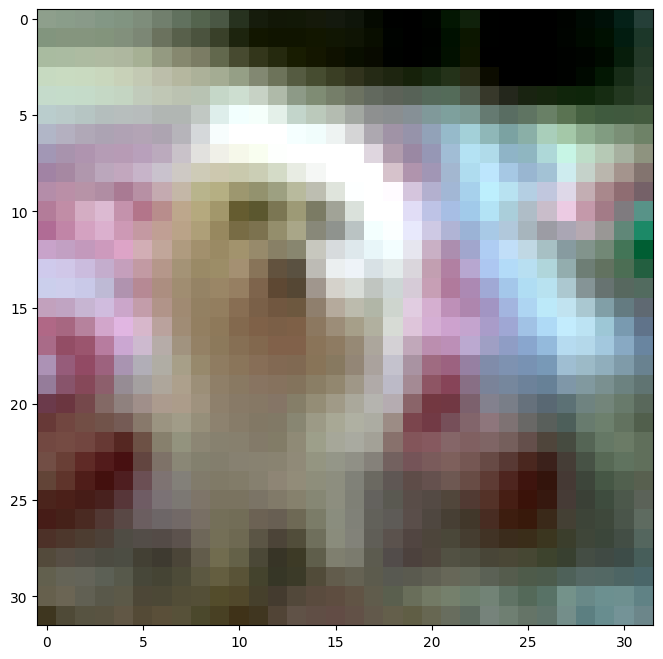

In [ ]:
for batch in train_dl:
    imgs, labels = batch
    break
    
plt.imshow(data_config.show(imgs[8]))

# Model Creation from Scratch

We rewrite the synapse and layer for a simple 2 layer CIFAR network

In [ ]:
class HopfieldNetworkAsSynapse(hmx.Synapse):
    """A simple reimplementation of a Hopfield Network as a synapse, returning the alignment"""
    W1: jnp.ndarray = tx.Parameter.node() # treex's preferred way of declaring an attribute as a parameter
    W2: jnp.ndarray = tx.Parameter.node()
    nhid: int
    beta: float = tx.Parameter.node()
    
    def __init__(self, nhid:int, beta_init=0.1):
        self.nhid = nhid
        self.beta = beta_init
    
    def __call__(self, g1, g2):
        """The alignment function, defined on an unbatched `g`"""
        if self.initializing():
            self.W1 = nn.initializers.normal(0.02)(tx.next_key(), g1.shape + (self.nhid,))
            self.W2 = nn.initializers.normal(0.02)(tx.next_key(), g2.shape + (self.nhid,))
        hidsig = g1 @ self.W1 + g2 @ self.W2
        hid_lagrangian_value = 1/self.beta * jnp.exp(self.beta * hidsig)
        return hid_lagrangian_value.sum(-1)
    
ImageLayer = hmx.Layer(hmx.lagrangians.LTanh(beta=0.1), (32*32*3,))
LabelLayer = hmx.Layer(hmx.lagrangians.LSoftmax(beta=0.1), (10,))

layers = [ImageLayer, LabelLayer]
synapses = [HopfieldNetworkAsSynapse(nhid=1000)]
connections = [((0,1),0)]
ham = hmx.HAM(layers, synapses, connections)

A layer is uniquely defined by a lagrangian function and a neuron shape

In [ ]:
def fwd(model, x, depth=4, dt=1, rng=None):
    """A pure function to extract desired information from the configured HAM, applied on batched inputs"""
    # Initialize hidden states to our image
    xs = model.init_states(x.shape[0], rng=rng)
    xs[0] = jnp.array(rearrange(x, "... c h w -> ... (c h w)"))

    # Masks allow us to clamp our visible data over time
    masks = jtu.tree_map(lambda x: jnp.ones_like(x, dtype=jnp.int8), xs)
    masks[0] = jnp.zeros_like(masks[0], dtype=jnp.int8)  # Don't evolve images

    for i in range(depth):
        updates = model.vupdates(xs)  # Calculate the updates
        xs = model.step(
            xs, updates, dt=dt, masks=masks
        )  # Add them to our current states

    # All labels have a softmax activation function as the last layer, spitting out probabilities
    return model.layers[-1].g(xs[-1])

In [ ]:
jax_key = jax.random.PRNGKey(0)
k1, jax_key = jax.random.split(jax_key)
lr = 0.001
num_epochs = 100
states, ham = ham.init_states_and_params(k1, bs=1)

In [ ]:
# ham, forward_classification = hmx.create_model(args.model)

optimizer = optax.adamw(0.001)
state = TrainState(
    ham,
    optimizer,
    fwd,
    rng=jax_key,
    filter_betas=False,
)


def get_nparams(model):
    params, meta = jtu.tree_flatten(model.parameters())

    def get_nel(x):
        try:
            return x.size
        except AttributeError:  # float
            return 1

    return sum([get_nel(p) for p in params])


def escape_ansi(line):
    import re

    ansi_escape = re.compile(r"(?:\x1B[@-_]|[\x80-\x9F])[0-?]*[ -/]*[@-~]")
    return ansi_escape.sub("", line)

logger.info(f"NParams={get_nparams(state.model)}")
logger.info(escape_ansi(state.model.tabulate()))

/nethome/bhoover30/miniconda3/envs/hamux/lib/python3.9/site-packages/treex/optimizer.py:79: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  params = jax.tree_leaves(params)
2022-10-18 15:31:21.411 | INFO     | __main__:<module>:31 - NParams=3082003
/nethome/bhoover30/miniconda3/envs/hamux/lib/python3.9/site-packages/treex/module.py:241: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  flat, _ = jax.tree_flatten(self)
/nethome/bhoover30/miniconda3/envs/hamux/lib/python3.9/site-packages/treex/utils.py:167: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  tree_types = jax.tree_flatten(
/nethome/bhoover30/miniconda3/envs/hamux/lib/python3.9/site-packages/treex/utils.py:375: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future r

┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ path                  ┃ module                ┃ params                ┃ Parameter         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ *                     │ HAM()                 │                       │                   │
├───────────────────────┼───────────────────────┼───────────────────────┼───────────────────┤
│ .layers[0]            │ Layer()               │ bias: None            │                   │
│                       │                       │                       │                   │
├───────────────────────┼───────────────────────┼───────────────────────┼───────────────────┤
│ .layers[0].lagrangian │ LTanh()               │ beta: 0.1             │                   │
│                       │                       │                       │                   │
├───────────────────────┼───────────────────────┼───────────────────────┼───────────────────┤
│ .layers[1]            │ Layer()               │ bias: None            │                   │
│                       │                       │                       │                   │
├───────────────────────┼───────────────────────┼───────────────────────┼───────────────────┤
│ .layers[1].lagrangian │ LSoftmax()            │ beta: 0.1             │                   │
│                       │                       │                       │                   │
├───────────────────────┼───────────────────────┼───────────────────────┼───────────────────┤
│ .synapses[0]          │ HopfieldNetworkAsSyn… │ W1: Parameter(3072,   │ 3,082,000  12.3MB │
│                       │                       │ 1000)  float32        │                   │
│                       │                       │ W2: Parameter(10,     │                   │
│                       │                       │ 1000)    float32      │                   │
│                       │                       │ beta: 0.1             │                   │
├───────────────────────┼───────────────────────┼───────────────────────┼───────────────────┤
│                       │                       │                Total: │ 3,082,000  12.3MB │
└───────────────────────┴───────────────────────┴───────────────────────┴───────────────────┘
                                                                                             
                             Total Parameters: 3,082,000  12.3MB                             

2022-10-18 15:31:21.424 | INFO     | __main__:<module>:32 - 


In [ ]:
# ===========================================
## Training
# ===========================================
@dataclass
class CkptTracker:
    base_name: str
    model: tx.Module = None
    epoch: int = -1
    best_acc: float = -1

    def get_save_name(self):
        return f"{self.base_name}_epoch-{self.epoch}_acc-{100*self.best_acc:.3f}.pckl"


train_acc_list = []
test_acc_list = []
ckpt_tracker = CkptTracker("DummyCifar")
logdir = Path("./_logs")
logdir.mkdir(exist_ok=True, parents=True)


with trange(1, num_epochs + 1, unit="epochs") as pbar:
    for epoch in pbar:
        state, train_loss, train_acc = train_epoch(state, train_dl, epoch)
        test_loss, test_acc = eval_model(state, eval_dl)
        if test_acc > ckpt_tracker.best_acc:
            old_ckpt_name = str(logdir / ckpt_tracker.get_save_name())
            try:
                os.remove(old_ckpt_name)
            except Exception as e:
                logger.debug(f"Couldn't remove {old_ckpt_name}, {e}")
                pass
            ckpt_tracker.model = state.model
            ckpt_tracker.epoch = epoch
            ckpt_tracker.best_acc = test_acc
            to_save = jtu.tree_map(hmx.utils.to_pickleable, ckpt_tracker.model.to_dict())
            ckpt_name = str(logdir / ckpt_tracker.get_save_name())
            hmx.utils.pytree_save(to_save, ckpt_name, overwrite=True)
        desc = f"[{epoch}/{num_epochs}] | BestAcc: {100*ckpt_tracker.best_acc:.3f} | TrainLoss: {train_loss:.2f} | TrainAcc: {100*train_acc:.2f}"
        addition = f"curr_val_acc={100*test_acc:0.2f}"
        logger.info(desc + " | " + addition)
        pbar.set_description(desc)
        pbar.set_postfix(
            train_acc=f"{100*train_acc:0.2f}", val_acc=f"{100*test_acc:0.2f}"
        )

  0%|                                                                                 | 0/500 [00:00<?, ?it/s]/nethome/bhoover30/miniconda3/envs/hamux/lib/python3.9/site-packages/treex/optimizer.py:110: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  opt_grads, treedef = jax.tree_flatten(grads)
/nethome/bhoover30/miniconda3/envs/hamux/lib/python3.9/site-packages/treex/optimizer.py:111: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  opt_params = jax.tree_leaves(params)
/nethome/bhoover30/miniconda3/envs/hamux/lib/python3.9/site-packages/treex/optimizer.py:135: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  return jax.tree_unflatten(treedef, output)

 99%|██████████████████████████████████████████████████████████████████████ | 493/500 [00:17<

KeyboardInterrupt: 

Brief analysis

In [ ]:
def fwd_energy(model, x, depth=4, dt=1, rng=None):
    """A pure function to extract desired information from the configured HAM, applied on batched inputs"""
    # Initialize hidden states to our image
    xs = model.init_states(x.shape[0], rng=rng)
    xs[0] = jnp.array(rearrange(x, "... c h w -> ... (c h w)"))

    # Masks allow us to clamp our visible data over time
    masks = jtu.tree_map(lambda x: jnp.ones_like(x, dtype=jnp.int8), xs)
    # masks[0] = jnp.zeros_like(masks[0], dtype=jnp.int8)  # Don't evolve images
    all_xs = [xs]
    energies = [model.venergy(xs)]

    for i in range(depth):
        updates = model.vupdates(xs)  # Calculate the updates
        xs = model.step(
            xs, updates, dt=dt, masks=masks
        )  # Add them to our current states
        all_xs.append(xs)
        energies.append(model.venergy(xs))

    # All labels have a softmax activation function as the last layer, spitting out probabilities
    return jnp.stack(energies), all_xs

In [ ]:
img_start = batch[0][:1]
# img_start = jnp.ones_like(jnp.array(img_start))
energies, allxs = fwd_energy(ham, img_start, dt=0.2, depth=30)

In [ ]:
from torchvision.utils import make_grid

def show_x(x):
    x = rearrange(x, "... (c h w) -> ... c h w", c=3, h=32, w=32)
    return data_config.show(torch.tensor(np.array(x)))

aa = make_grid([rearrange(torch.tensor(show_x(x[0][0])), "h w c -> c h w") for x in allxs])

plt.imshow(np.array(rearrange(aa, "c h w -> h w c")))

In [ ]:
plt.plot(energies)

In [ ]:
# img_start = batch[0][:1]
# img_start = jnp.ones_like(jnp.array(img_start))
# # energies, allxs = fwd_energy(ham, img_start, dt=0.1, depth=60)